# Check Fitting Function

This notebook demonstrates the fitting of a single SDSS target with the analysis pipeline. It is important to note that the full analysis uses nested sampling to determine model specific fitting priors for each individual object. We do not consider that process here, but restrict our scope to ensuring the core fitting functionality of the analysis pipeline returns reasonable results.

In [1]:
import sys

import numpy as np
import sncosmo
from astropy.table import Table
from matplotlib import pyplot as plt

sys.path.insert(0, '../')
from analysis_pipeline import fit_lc
from SNData.sdss import sako18

# Make sure SDSS data is locally available and registered with SNCosmo
sako18.download_module_data()
sako18.register_filters()


## Notes on data handling

For completeness, we note that the `SNData` package uses SDSS bandpasses from Doi et al. 2010. These are the same filters when fitting SDSS light curves.

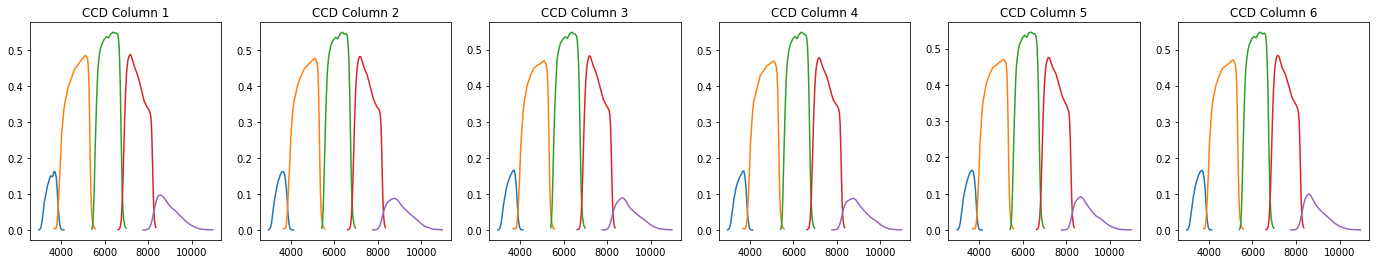

In [2]:
fig, axes = plt.subplots(1, 6, figsize=(24, 4))
for i, axis in enumerate(axes):
    for band in 'ugriz':
        band = sncosmo.get_bandpass('sdss_sako18_{}{}'.format(band, i + 1))
        axis.plot(band.wave, band.trans)
        axis.set_title('CCD Column {}'.format(i + 1))


We also note that the published SDSS data set includes flags notating outlier data points. These observations are automatically removed by `SNData`

## Picking an example target

For our demonstration, we specifically focus on targets that are spectroscopically confirmed SNe Ia. These can be isolated from the published SDSS data by selecting targets classified as `SNIa`.

In [3]:
master_table = sako18.load_table('master')
master_table_indices = master_table['Classification'] == 'SNIa'
spec_confirmed_sn = master_table[master_table_indices]

print('A sample of the SDSS published results for spectroscopically confirmed SNe Ia:')
spec_confirmed_sn[:5]


A sample of the SDSS published results for spectroscopically confirmed SNe Ia:


CID,RA,DEC,Nsearchepoch,IAUName,Classification,Peakrmag,MJDatPeakrmag,NepochSNR5,nSNspec,nGALspec,zspecHelio,zspecerrHelio,zCMB,zerrCMB,x0SALT2zspec,x0errSALT2zspec,x1SALT2zspec,x1errSALT2zspec,cSALT2zspec,cerrSALT2zspec,PeakMJDSALT2zspec,PeakMJDderrSALT2zspec,muSALT2zspec,muerrSALT2zspec,fitprobSALT2zspec,chi2SALT2zspec,ndofSALT2zspec,deltaMLCS2k2zspec,deltaerrMLCS2k2zspec,avMLCS2k2zspec,averrMLCS2k2zspec,PeakMJDMLCS2k2zspec,PeakMJDerrMLCS2k2zspec,muMLCS2k2zspec,muerrMLCS2k2zspec,fitprobMLCS2k2zspec,chi2MLCS2k2zspec,ndofMLCS2k2zspec,PIaPSNIDzspec,logprobIaPSNIDzspec,lcqualityIaPSNIDzspec,PIbcPSNIDzspec,logprobIbcPSNIDzspec,lcqualityIbcPSNIDzspec,PIIPSNIDzspec,logprobIIPSNIDzspec,lcqualityIIPSNIDzspec,NnnPSNIDzspec,PnnIaPSNIDzspec,PnnIbcPSNIDzspec,PnnIIPSNIDzspec,zPSNIDzspec,zerrPSNIDzspec,dm15PSNIDzspec,dm15errPSNIDzspec,avPSNIDzspec,averrPSNIDzspec,PeakMJDPSNIDzspec,PeakMJDerrPSNIDzspec,SNIbctypePSNIDzspec,SNIItypePSNIDzspec,x0SALT2flat,x0errSALT2flat,x1SALT2flat,x1errSALT2flat,cSALT2flat,cerrSALT2flat,PeakMJDSALT2flat,PeakMJDerrSALT2flat,zphotSALT2flat,zphoterrSALT2flat,fitprobSALT2flat,chi2SALT2flat,ndofSALT2flat,PIaPSNIDflat,logprobIaPSNIDflat,lcqualityIaPSNIDflat,PIbcPSNIDflat,logprobIbcPSNIDflat,lcqualityIbcPSNIDflat,PIIPSNIDflat,logprobIIPSNIDflat,lcqualityIIPSNIDflat,NnnPSNIDflat,PnnIaPSNIDflat,PnnIbcPSNIDflat,PnnIIPSNIDflat,zPSNIDflat,zerrPSNIDflat,dm15PSNIDflat,dm15errPSNIDflat,avPSNIDflat,averrPSNIDflat,PeakMJDPSNIDflat,PeakMJDerrPSNIDflat,SNIbctypePSNIDflat,SNIItypePSNIDflat,objIDHost,RAhost,DEChost,separationhost,DLRhost,zphothost,zphoterrhost,zphotRFhost,zphotRFerrhost,dereduhost,erruhost,deredghost,errghost,deredrhost,errrhost,deredihost,errihost,deredzhost,errzhost,logMassFSPS,logMassloFSPS,logMasshiFSPS,logSSFRFSPS,logSSFRloFSPS,logSSFRhiFSPS,ageFSPS,ageloFSPS,agehiFSPS,minredchi2FSPS,logMassPEGASE,logMassloPEGASE,logMasshiPEGASE,logSFRPEGASE,logSFRloPEGASE,logSFRhiPEGASE,agePEGASE,minchi2PEGASE,Notes
str21,float64,float64,int64,str6,str8,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,float64,float64,int64,float64,float64,int64,float64,float64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64
722,0.705703,0.751234,20,2005ed,SNIa,19.2,53623.3,19,1,1,0.086341,3.6e-05,0.085038,3.6e-05,--,--,--,--,--,--,--,--,--,--,--,--,--,-0.14,0.09,0.04,0.11,53609.3,0.92,38.34,0.11,1.0,29.9,62,1.0,0.0,23,0.0,-27.2,63,0.0,-146.0,55,--,--,--,--,0.0892,0.0071,0.96,0.06,-0.09,0.19,53607.81,0.95,1,1,--,--,--,--,--,--,--,--,--,--,--,--,--,1.0,0.0,19,0.0,-25.1,59,0.0,-40.1,51,-1,-1.0,-1.0,-1.0,0.0931,0.0071,0.95,0.06,-0.07,0.19,53607.94,1.11,303,301,1237657191979286607,0.705965,0.751865,2.22,0.67,0.0879,0.0131,0.0903,0.0194,19.129,0.06,17.179,0.006,16.266,0.005,15.898,0.005,15.528,0.01,10.97,10.9,11.02,-15.23,-40.58,-12.7,6.66,5.66,8.55,1.35,10.83,10.76,10.93,-99.0,-99.0,-99.0,4.0,39.22,--
739,14.595315,0.679056,11,2005ef,SNIa,19.4,53616.4,14,1,1,0.107638,1.8e-05,0.106421,1.8e-05,0.000405,3.35e-05,-0.88,0.2,-0.0,0.04,53609.5,1.1,38.32,0.18,0.001,58.6,29,0.11,0.11,0.1,0.12,53607.4,1.08,38.58,0.12,0.169,72.5,62,1.0,-0.194,19,0.0,-38.2,19,0.0,-138.0,3,--,--,--,--,0.1054,0.0077,1.06,0.06,0.28,0.17,53607.05,1.18

Next, we pick fit an arbitrary object ID and retrieve the published values. 

Example_id: 739

Published values:
  z:  0.106421
  t0: 53616.4
  x0: 0.000405
  x1: -0.88
  c:  -0.0
  Normalized chi-squared: 2.020689655172414

The lightcurve:


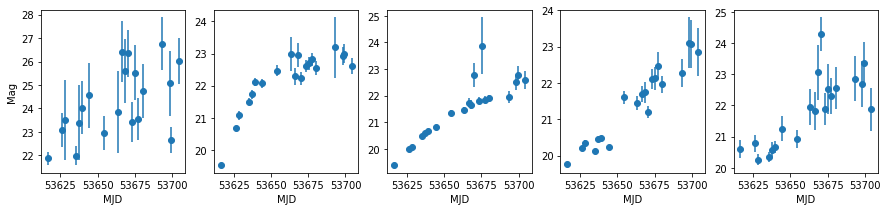


A subset of the data table:


FLAG,MJD,FILT,MAG,MERR,MSKYERR,MGALERR,FLUX,FLUXERR,SKYERR,GALERR,NPRE,TELE,RUN,STRIP,IDCCD
int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str4,int64,str3,int64
0,53616.355168,1,19.556,0.026,0.01,0.016,53.66,1.275,0.477,0.7762,19,sdss,5566,82N,5
0,53616.35185,2,19.403,0.024,0.004,0.016,62.65,1.369,0.247,0.9348,19,sdss,5566,82N,5
0,53616.35268,3,19.776,0.044,0.019,0.027,43.89,1.79,0.7521,1.105,19,sdss,5566,82N,5
32,53616.354338,4,20.607,0.29,0.123,0.217,20.22,5.447,2.355,4.171,20,sdss,5566,82N,5
8,53616.353509,0,21.865,0.293,0.236,0.342,6.895,1.809,1.495,2.165,17,sdss,5566,82N,5
0,53626.332216,1,20.684,0.041,0.008,0.024,18.98,0.7105,0.1465,0.422,19,sdss,5603,82N,5
0,53626.328899,2,19.984,0.029,0.009,0.013,36.69,0.9879,0.3133,0.45,19,sdss,5603,82N,5
0,53626.329728,3,20.214,0.053,0.017,0.021,29.31,1.417,0.4453,0.5695,19,sdss,5603,82N,5
32,53626.331387,4,20.784,0.277,0.09,0.194,17.07,4.469,1.484,3.183,20,sdss,5603,82N,5


In [4]:
test_id = '739'
published_values = spec_confirmed_sn[spec_confirmed_sn['CID'] == test_id][0]
print('Example_id:', test_id)

print('\nPublished values:')
print('  z: ', published_values['zCMB'])
print('  t0:', published_values['MJDatPeakrmag'])
print('  x0:', published_values['x0SALT2zspec'])
print('  x1:', published_values['x1SALT2zspec'])
print('  c: ', published_values['cSALT2zspec'])

chisq_norm = published_values['chi2SALT2zspec'] / published_values['ndofSALT2zspec']
print('  Normalized chi-squared:', chisq_norm)

print('\nThe lightcurve:')
test_data = sako18.get_data_for_id(test_id)
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    band_data = test_data[test_data['FILT'] == i]
    axes[i].scatter(band_data['MJD'], band_data['MAG'])
    axes[i].errorbar(band_data['MJD'], band_data['MAG'], yerr=band_data['MERR'], linestyle='')
    axes[i].set_xlabel('MJD')

axes[0].set_ylabel('Mag')
plt.show()

print('\nA subset of the data table:')
test_data[:10]


# Light curve fitting

Using the data shown above, we fit an arbitrary light curve and check that the results we receive from the pipeline are the same as those we would receive from running SNCosmo directly.

/anaconda3/envs/sdss_class/lib/python3.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdss_sako18_z5(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)
/anaconda3/envs/sdss_class/lib/python3.7/site-packages/sncosmo/models.py:737: RuntimeWarning: invalid value encountered in true_divide
  result = v * (f0 / ftot)**2 * scale**2



Pipeline results:
  z:  0.106421
  t0: 53612.97526876672
  x0: 0.00024396375473203756
  x1: -1.3646062854205532
  c:  0.07521338234819573
  Normalized chi-squared: 5.6377979387872275


/anaconda3/envs/sdss_class/lib/python3.7/site-packages/sncosmo/fitting.py:160: RuntimeWarning: Dropping following bands from data: sdss_sako18_z5(out of model wavelength range)
  "(out of model wavelength range)", RuntimeWarning)



SNCosmo values:
  z:  0.106421
  t0: 53612.97526876672
  x0: 0.00024396375473203756
  x1: -1.3646062854205532
  c:  0.07521338234819573
  Normalized chi-squared: 8.309060508827985

SNCosmo Plot:


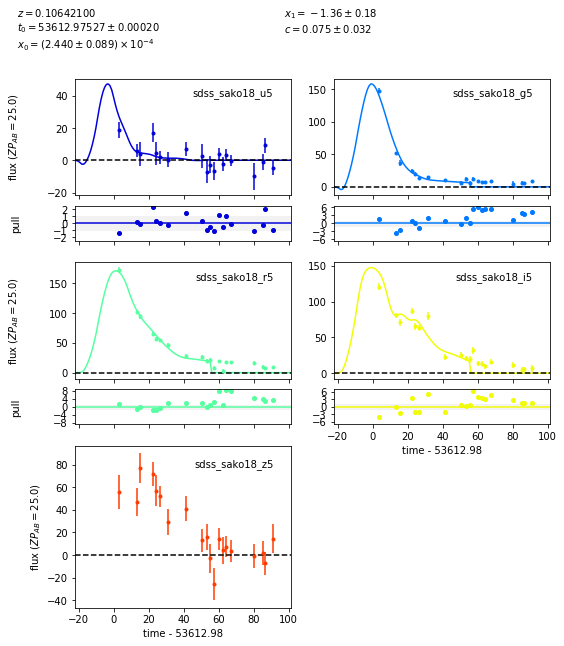

In [5]:
# Get an input table formatted for use with SNCosmo
input_table = sako18.get_sncosmo_input(test_id)

# Create a Salt2.0 model
source = sncosmo.get_source('salt2', version='2.0')
model = sncosmo.Model(source=source)
model.set(z=input_table.meta['redshift'])

# Run the fit with the pipeline
pipeline_results = fit_lc(input_table, model, ['t0', 'x0', 'x1', 'c'], modelcov=True)
print('\nPipeline results:')
print('  z: ', pipeline_results[2])
print('  t0:', pipeline_results[3])
print('  x0:', pipeline_results[4])
print('  x1:', pipeline_results[5])
print('  c: ', pipeline_results[6])
print('  Normalized chi-squared:', pipeline_results[10] / pipeline_results[11])

# Run the fit with SNCosmo
sncosmo_result, fitted_model = sncosmo.fit_lc(
    input_table, 
    model, ['t0', 'x0', 'x1', 'c'], 
    modelcov=True
)

print('\nSNCosmo values:')
print('  z: ', sncosmo_result.parameters[0])
print('  t0:', sncosmo_result.parameters[1])
print('  x0:', sncosmo_result.parameters[2])
print('  x1:', sncosmo_result.parameters[3])
print('  c: ', sncosmo_result.parameters[4])
print('  Normalized chi-squared:',
     sncosmo_result.chisq / sncosmo_result.ndof)

print('\nSNCosmo Plot:')
sncosmo.plot_lc(input_table, model=fitted_model, errors=sncosmo_result.errors)
plt.show()


Finally we take a look at the published values.

In [6]:
print('\nPipeline results:')
print('  z: ', pipeline_results[2])
print('  t0:', pipeline_results[3])
print('  x0:', pipeline_results[4])
print('  x1:', pipeline_results[5])
print('  c: ', pipeline_results[6])
print('  Normalized chi-squared:', pipeline_results[10] / pipeline_results[11])

print('\nPublished values:')
print('  z: ', published_values['zCMB'])
print('  t0:', published_values['MJDatPeakrmag'])
print('  x0:', published_values['x0SALT2zspec'])
print('  x1:', published_values['x1SALT2zspec'])
print('  c: ', published_values['cSALT2zspec'])
print('  Normalized chi-squared:', chisq_norm)


Pipeline results:
  z:  0.106421
  t0: 53612.97526876672
  x0: 0.00024396375473203756
  x1: -1.3646062854205532
  c:  0.07521338234819573
  Normalized chi-squared: 5.6377979387872275

Published values:
  z:  0.106421
  t0: 53616.4
  x0: 0.000405
  x1: -0.88
  c:  -0.0
  Normalized chi-squared: 2.020689655172414
